In [1]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("/uscms/home/kyungmip/nobackup/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

## Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [6]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [7]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [8]:
#suffix = "_ejdR_rejection_IDcut"
suffix = "_BDT"

In [10]:
sample_json_dir = './'
jsons = [f for f in os.listdir(sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "signal" in samp ]
print(signal_list)

bkg_list = [ samp.split('.')[0] for samp in jsons if "bkg" in samp ]
print(bkg_list)

['signal_v2_2018_aEM']
['bkg_2018_Diboson', 'bkg_2018_DY', 'bkg_2018_QCD_TuneCP5_PSWeights', 'bkg_2018_Top', 'bkg_2018_Triboson', 'bkg_2018_TTJetsDiLept', 'bkg_2018_WJets', 'bkg_2018_ZJets']


In [12]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{samp}.json")
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: signal_v2_2018_aEM


Output()

Completed in 1.35 min



In [14]:
for samp in bkg_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{samp}.json")
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: bkg_2018_Diboson


Output()

Output()

Completed in 0.79 min

Start analyzing: bkg_2018_DY


Output()

Output()

Completed in 0.71 min

Start analyzing: bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 1.34 min

Start analyzing: bkg_2018_Top


Output()

Output()

Completed in 3.52 min

Start analyzing: bkg_2018_Triboson


Output()

Output()

Completed in 0.33 min

Start analyzing: bkg_2018_TTJetsDiLept


Output()

Output()

Completed in 0.84 min

Start analyzing: bkg_2018_WJets


Output()

Output()

Completed in 2.90 min

Start analyzing: bkg_2018_ZJets


Output()

Output()

Completed in 2.56 min



## BDT

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [17]:
sig_files

['signal_v2_2018_aEM_BDT.h5']

In [20]:
h5_dir = "./h5/"
suffix = "_BDT"

sig_files = [f for f in os.listdir(h5_dir) if suffix in f and 'signal' in f]
bkg_files = [f for f in os.listdir(h5_dir) if suffix in f and 'bkg' in f]


variables = ['lead_jet_eta','lead_jet_pt','jetMETdPhi','minJetMETdPhi','sel_vtx_sign',
             'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy',
             'met_leadPt_ratio','vxy_signif']

sig_data = []
for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
sig_data = np.concatenate(sig_data,axis=0)

nBkg = 0
bkg_data = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[2]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))

print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 20574 -> 4579 after gen matching (raw counts)

Diboson: 2317
DY: 25
QCD: 725
Top: 8467
Triboson: 310
TTJetsDiLept: 1266
WJets: 89850
ZJets: 125841

Number of total background events (raw counts): 228801


### Background raw counts

In [21]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[2]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

Diboson: 2317
DY: 25
QCD: 725
Top: 8467
Triboson: 310
TTJetsDiLept: 1266
WJets: 89850
ZJets: 125841


### Cutflow counts (xsec weighted)

In [22]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[2]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

Diboson: 577.1982629001141
DY: 2758.167739868164
QCD: 2948.0585146844387
Top: 987.1654803752899
Triboson: 7.3438074961304665
TTJetsDiLept: 137.8794869184494
WJets: 31587.113397152105
ZJets: 15902.592084169271
Total background counts (xsec weighted): 54905.51877356396


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`
Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct. 

In [23]:
sf = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[2]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        print(f'{process}: {entries}')

        sf[process] = entries

Diboson: [0.90153903 0.90153903 0.90153903 ... 1.21295648 1.21295648 1.21295648]
DY: [ 598.02718767  598.02718767  598.02718767  598.02718767  100.39135835
  100.39135835  100.39135835  100.39135835 7093.83623108  100.39135835
  100.39135835  100.39135835  100.39135835  100.39135835  100.39135835
  100.39135835  100.39135835  100.39135835  100.39135835  100.39135835
  100.39135835  100.39135835  100.39135835  100.39135835  100.39135835]
QCD: [3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26829768e+01 3.26829768e+01 3.26829768e+01 3.26829768e+01
 3.26

#### With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now. 

In [24]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

Diboson: 2405.2871475832285
DY: 11493.772148717428
QCD: 12285.080620375029
Top: 4113.692889767824
Triboson: 30.6029427963773
TTJetsDiLept: 574.5682036968474
WJets: 131629.085021837
ZJets: 66268.91126215417
228801.0002369279


In [25]:
nBkg

228801

In [63]:
sig_data.shape

(4579, 12)

In [26]:
# SF
bkg_sf = []
for process in sf.keys():
    bkg_sf += list(sf[process])

#print(len(bkg_sf))

### Train -- Bkg Reweighted

In [42]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = np.ones(sig_data.shape[0])

In [43]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [44]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)

# make predictions
preds = bst.predict(test)

Text(0.5, 1.0, 'BDT Prediction for the Test Dataset')

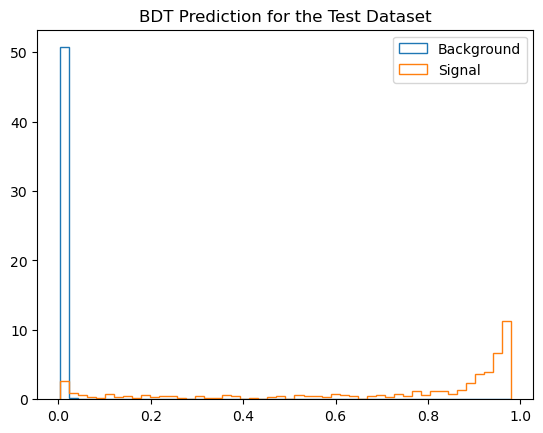

In [45]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

#plt.savefig('plots/BDTscore.png')
#plt.yscale('log')

[Text(0, 0, 'sel_vtx_sign'),
 Text(0, 1, 'jetMETdPhi'),
 Text(0, 2, 'met_leadPt_ratio'),
 Text(0, 3, 'lead_jet_eta'),
 Text(0, 4, 'lead_jet_pt'),
 Text(0, 5, 'vxy_signif'),
 Text(0, 6, 'minJetMETdPhi'),
 Text(0, 7, 'sel_vtx_dR'),
 Text(0, 8, 'sel_vtx_METdPhi'),
 Text(0, 9, 'sel_vtx_chi2'),
 Text(0, 10, 'sel_vtx_m'),
 Text(0, 11, 'sel_vtx_minDxy')]

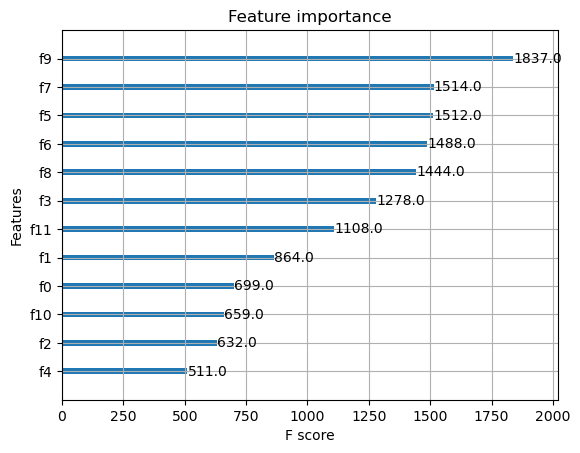

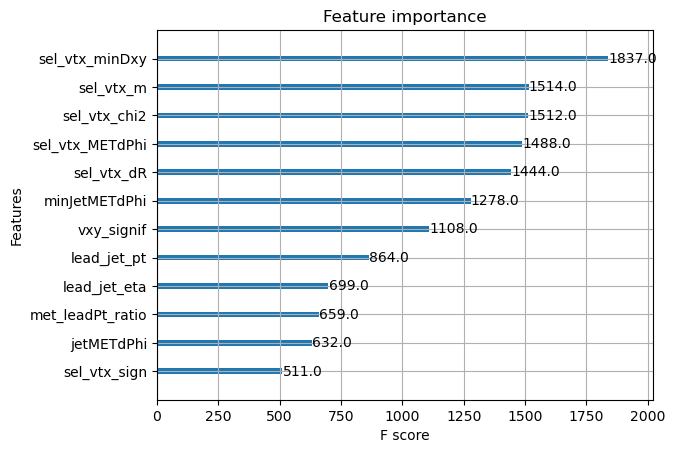

In [46]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

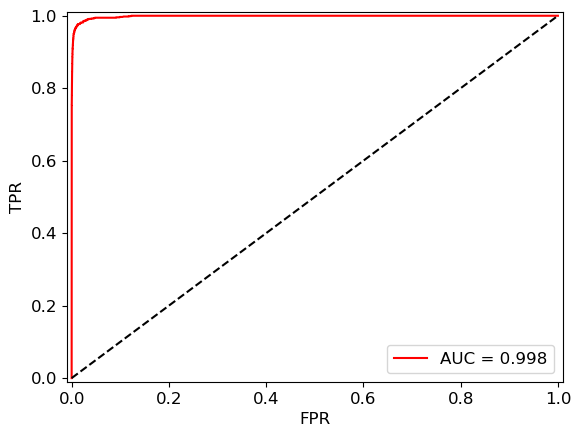

In [47]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### Train -- Bkg NOT weighted

In [48]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train)

# make predictions
preds = bst.predict(test)

Text(0.5, 1.0, 'BDT Prediction for the Test Dataset')

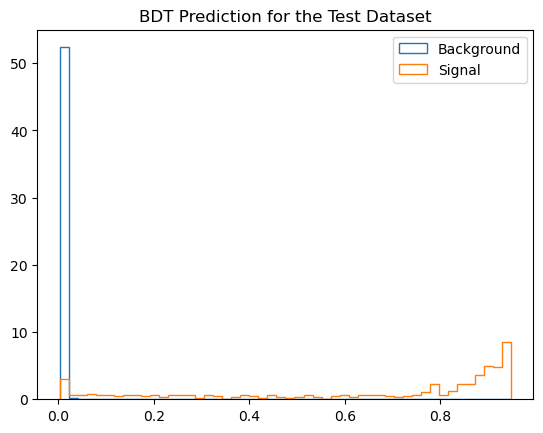

In [49]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

#plt.savefig('plots/BDTscore.png')
#plt.yscale('log')

[Text(0, 0, 'sel_vtx_sign'),
 Text(0, 1, 'lead_jet_eta'),
 Text(0, 2, 'met_leadPt_ratio'),
 Text(0, 3, 'jetMETdPhi'),
 Text(0, 4, 'lead_jet_pt'),
 Text(0, 5, 'vxy_signif'),
 Text(0, 6, 'minJetMETdPhi'),
 Text(0, 7, 'sel_vtx_METdPhi'),
 Text(0, 8, 'sel_vtx_chi2'),
 Text(0, 9, 'sel_vtx_m'),
 Text(0, 10, 'sel_vtx_dR'),
 Text(0, 11, 'sel_vtx_minDxy')]

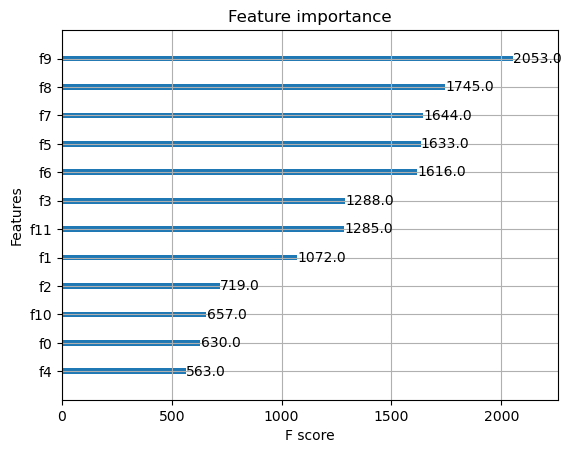

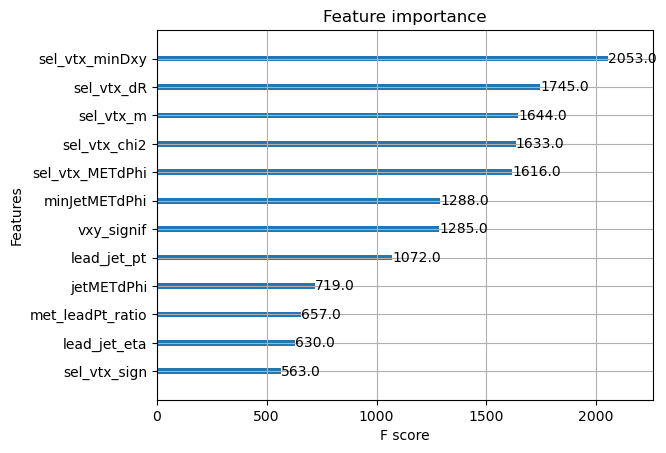

In [50]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

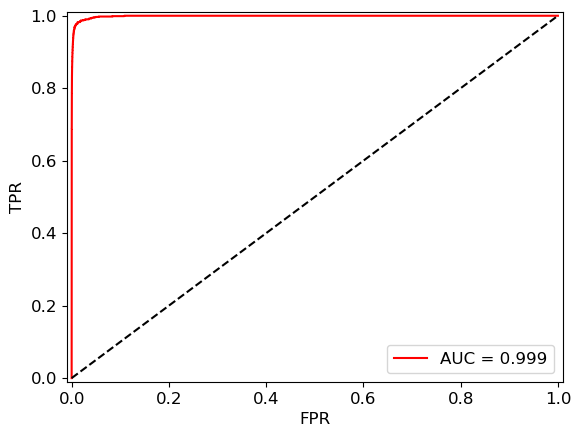

In [59]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### Reweight both sig & bkg: "augment" signal contributions such that sig:bkg ~ 1:1

In [64]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = np.ones(sig_data.shape[0])*(bkg_data.shape[0]/sig_data.shape[0])

In [66]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [67]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)

# make predictions
preds = bst.predict(test)

Text(0.5, 1.0, 'BDT Prediction for the Test Dataset')

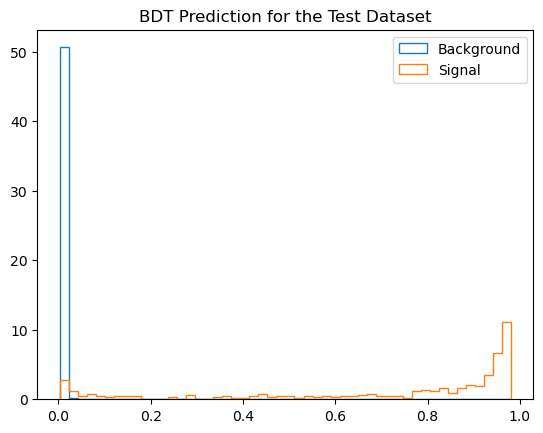

In [68]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

#plt.savefig('plots/BDTscore.png')
#plt.yscale('log')

[Text(0, 0, 'sel_vtx_sign'),
 Text(0, 1, 'met_leadPt_ratio'),
 Text(0, 2, 'jetMETdPhi'),
 Text(0, 3, 'lead_jet_eta'),
 Text(0, 4, 'lead_jet_pt'),
 Text(0, 5, 'minJetMETdPhi'),
 Text(0, 6, 'vxy_signif'),
 Text(0, 7, 'sel_vtx_chi2'),
 Text(0, 8, 'sel_vtx_m'),
 Text(0, 9, 'sel_vtx_dR'),
 Text(0, 10, 'sel_vtx_METdPhi'),
 Text(0, 11, 'sel_vtx_minDxy')]

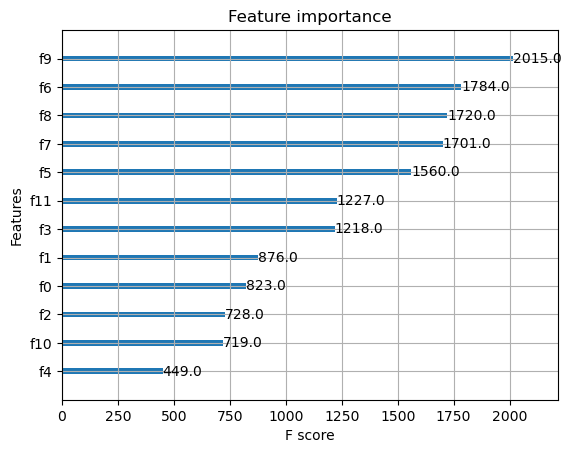

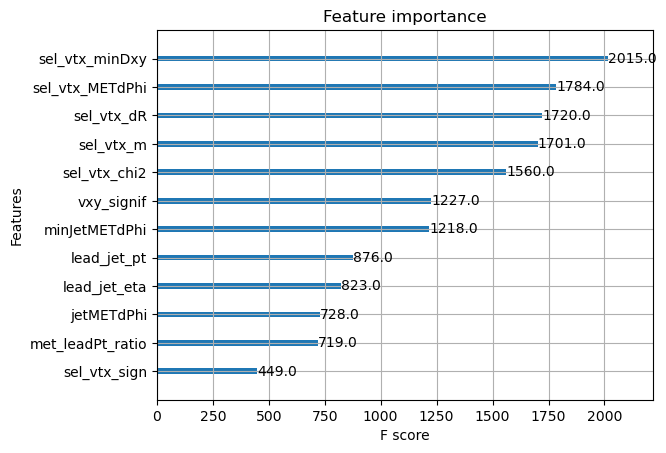

In [69]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

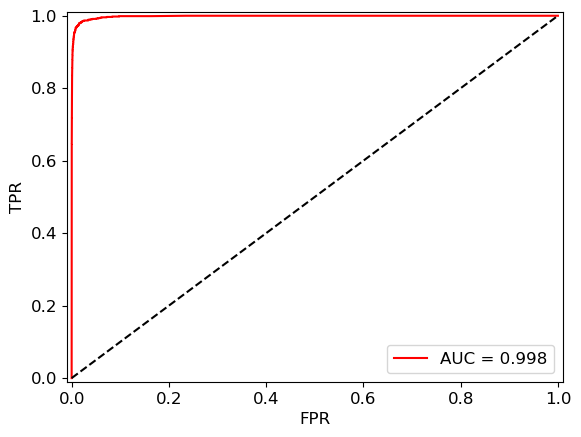

In [70]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### Pearson Correlation Coefficient

In [51]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [54]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

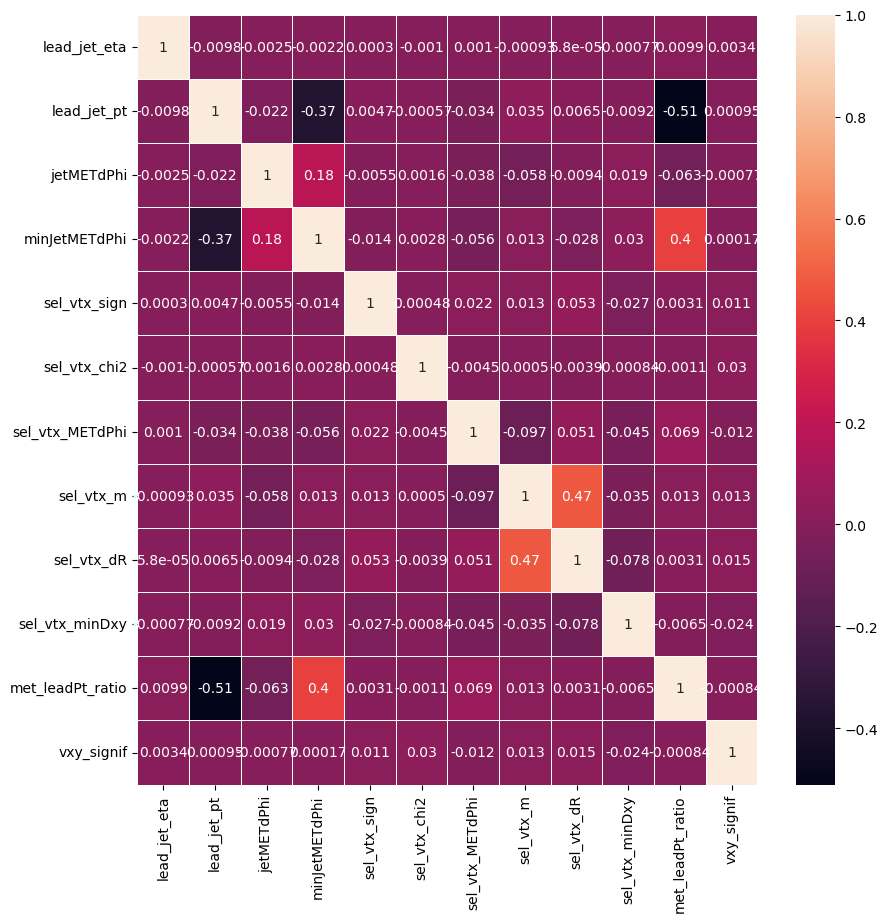

In [55]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 228801)')

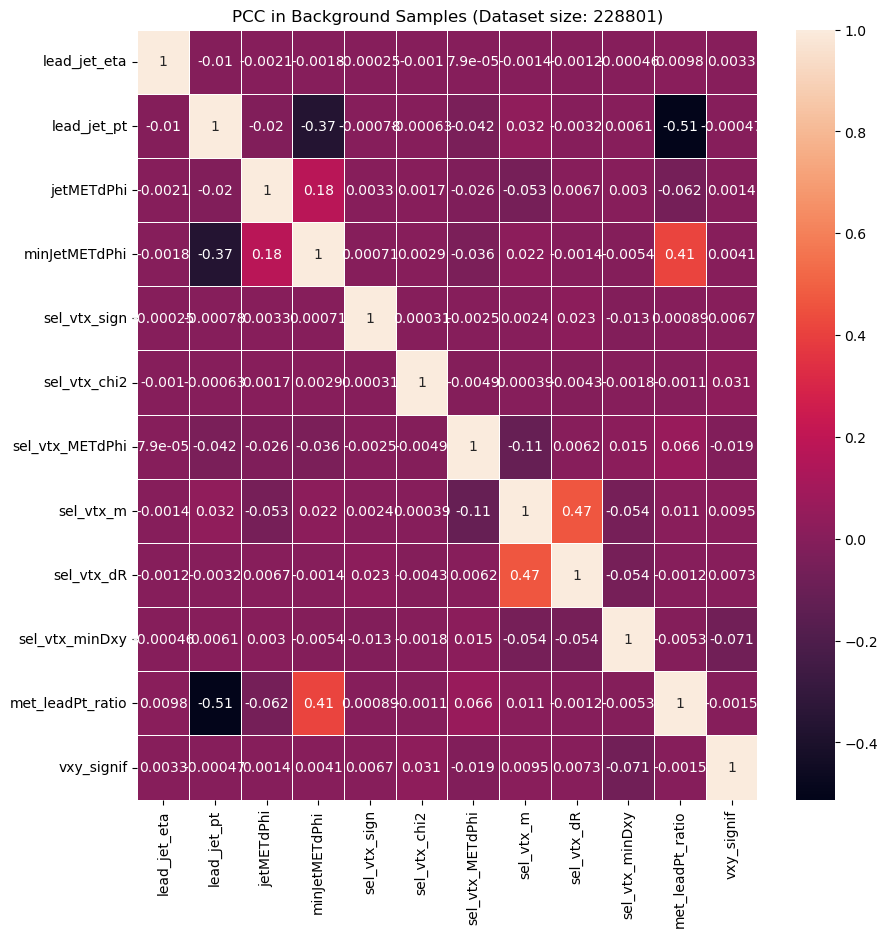

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})')

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 4579)')

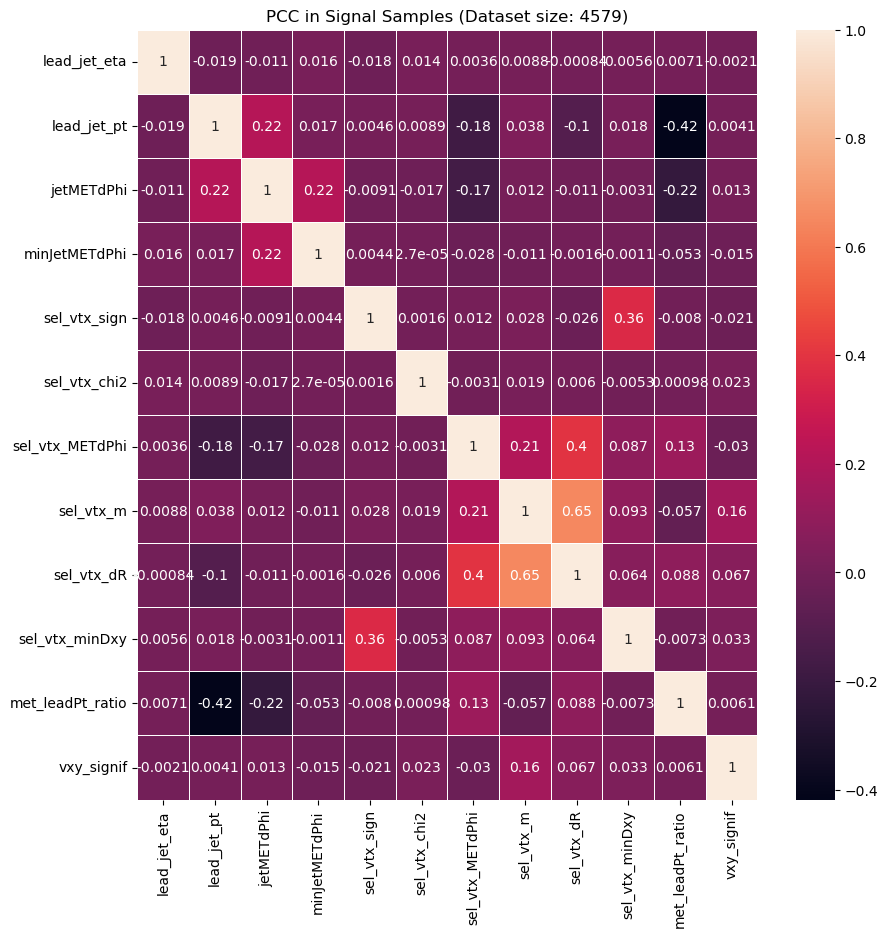

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')